In [1]:
suppressMessages(require(ggplot2))
suppressMessages(require(data.table))
suppressMessages(require(gplots))
suppressMessages(require(Seurat))
suppressMessages(require(Matrix))
source("VDJ_ploting_suite.R")
source("VDJ_function_pack.R")
suppressMessages(require(xlsx))
suppressMessages(require(ggplot2))
suppressMessages(require(reshape))
suppressMessages(require(scales))

load("180607_VDJinfo.Rdata")
load("180607_misc.Rdata")
base_Rdata_name="180607_RUVscale"

In [29]:
Exp_Seurat@raw.data=Exp_Seurat@raw.data[,match(colnames(Exp_Seurat@data),colnames(Exp_Seurat@raw.data))]
saveRDS(Exp_Seurat,file="Exp_Seurat_Bcell.Rds")

In [3]:
Exp_Seurat=readRDS(file="Exp_Seurat_Bcell.Rds")
#load("abgdTcell_labeling.Rdata")
tag_celltype="Bcell"

#cell type assignment
Bcell_assignment_df=data.frame(cluster=c("6,14,5,2,13,10,12","3,0,1,8","11","4,7,9"),
                                  celltype=c("Plasma","Memory_B","Breg","Naive_B"),
                                  stringsAsFactors=F)
Bcell_assignment_expanded=cellTypeDF_processing(Bcell_assignment_df)
Bcell_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),Bcell_assignment_expanded$cluster,Bcell_assignment_expanded$celltype)
Bcellsubcelltype_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),Bcell_assignment_expanded$cluster,Bcell_assignment_expanded$subcelltype)


In [4]:
#select target annotation
tag_annotation=BCR_annoation[which(BCR_annoation$is_cell & BCR_annoation$high_confidence & BCR_annoation$productive),] 
tag_annotation=tag_annotation[!(tag_annotation$chain %in% c("Multi")),]
#tag_annotation=rbind(TCR_annoation,TCR_annoation_w)
format(object.size(tag_annotation),units="Mb")

[1] "123.9 Mb"

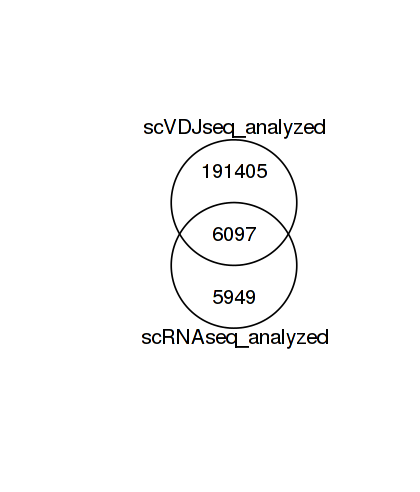

In [5]:
options(repr.plot.width=3.5, repr.plot.height=4.1)
venn(list(scRNAseq_analyzed=colnames(Exp_Seurat@data),scVDJseq_analyzed=unique(tag_annotation$barcode)),small=0.5)

###   make cell-VDJC matrix

In [9]:
batch_info=data.frame(batch=sample_list,
                      patient_id=gsub("_.*","",sample_list),
                      tissue_type=gsub(".*_","",sample_list),
                      disease_status=substring(sample_list, 1, 1))

all_barcode=unique(tag_annotation$barcode)
all_v=unique(tag_annotation$v_gene)
all_d=unique(tag_annotation$d_gene)
all_j=unique(tag_annotation$j_gene)
all_c=unique(tag_annotation$c_gene)

position_index_matrix=matrix(0,nrow(tag_annotation),14)
colnames(position_index_matrix)=c("barcode","v_gene","d_gene","j_gene","c_gene","cdr3","cdr3_nt","celltype","batch_id","tissue_type","patient_id","disease","clone_id","expand_lvl") #
position_index_matrix=data.frame(position_index_matrix)
position_index_matrix$barcode=tag_annotation$barcode #match(tag_annotation$barcode,all_barcode)
position_index_matrix$v_gene=tag_annotation$v_gene #match(tag_annotation$v_gene,all_v)
position_index_matrix$d_gene=tag_annotation$d_gene #match(tag_annotation$d_gene,all_d)
position_index_matrix$j_gene=tag_annotation$j_gene #match(tag_annotation$j_gene,all_j)
position_index_matrix$c_gene=tag_annotation$c_gene #match(tag_annotation$c_gene,all_c)
position_index_matrix$cdr3=tag_annotation$cdr3
position_index_matrix$cdr3_nt=tag_annotation$cdr3_nt

position_index_matrix$celltype=Bcellsubcelltype_assignment[match(tag_annotation$barcode,colnames(Exp_Seurat@data))]

tmp=strsplit(tag_annotation$barcode, "-")
batch_belonging=as.numeric(lapply(tmp,function(x){return(x[2])}))
position_index_matrix$batch_id=sample_list[batch_belonging]

patients=unique(gsub("_.*","",sample_list))
for(i in 1:length(patients)){
    position_index_matrix$patient_id[batch_belonging %in% grep(patients[i],sample_list)]=patients[i]
}

tissues=c("pBMC","I","R")
for(i in 1:length(tissues)){
    position_index_matrix$tissue_type[batch_belonging %in% grep(tissues[i],sample_list)]=tissues[i]
}

position_index_matrix$disease="healthy"
position_index_matrix$disease[grep("U",position_index_matrix$patient_id)]="ill"

#filter problematic rows
position_index_matrix=position_index_matrix[!position_index_matrix$batch_id %in% c("C19_pBMC","C19_I"),] #C19 I and P have problem
batch_info=batch_info[batch_info$batch %in% unique(position_index_matrix$batch_id),]

#clonetype
clone_type=paste0(position_index_matrix$v_idx,"_",position_index_matrix$d_idx,"_",position_index_matrix$j_idx,"_",position_index_matrix$cdr3_nt)

for(i in 1:length(patients)){
    tag_posi=which(position_index_matrix$patient_id==patients[i])
    tag_clone_types=clone_type[tag_posi]
    position_index_matrix$clone_id[tag_posi]=paste0(patients[i],"_clone_",as.numeric(as.factor(tag_clone_types)))
}

#expansion_level
exp_lvl=table(position_index_matrix$clone_id)
position_index_matrix$expand_lvl=exp_lvl[match(position_index_matrix$clone_id,names(exp_lvl))]

saveRDS(position_index_matrix,file="B_cell_position_index_matrix.rds")

##### VDJC gene usage

In [26]:
source("VDJ_function_pack.R")
plot_usage(position_index_matrix,tag_col="v_gene",out_name="B cell v_gene usage.pdf",out_height=12,out_width=35,
          lhei=c(0.8,5),lwid=c(0.5,5),margins=c(10,12),notecex=0.75,colorby="row")
plot_usage(position_index_matrix,tag_col="d_gene",out_name="B cell d_gene usage.pdf",out_height=12,out_width=13,
          lhei=c(0.8,5),lwid=c(2,5),margins=c(14,10),notecex=0.75,colorby="row")
plot_usage(position_index_matrix,tag_col="j_gene",out_name="B cell j_gene usage.pdf",out_height=12,out_width=15,
          lhei=c(0.8,5),lwid=c(0.5,5),margins=c(10,12),notecex=0.75,colorby="row")
plot_usage(position_index_matrix,tag_col="c_gene",out_name="B cell c_gene usage.pdf",out_height=12,out_width=10,
          lhei=c(0.8,5),lwid=c(2,5),margins=c(14,10),notecex=0.75,colorby="row")


png 
  2

png 
  2

png 
  2

png 
  2

### clone type analysis
##### per condition

In [11]:
target_condition="patient_id"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=10,plot_height=4,TorB="Bcell")

target_condition="celltype"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=10,plot_height=5.5,TorB="Bcell")

target_condition="batch_id"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=15,plot_height=4,TorB="Bcell")

target_condition="tissue_type"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=4,plot_height=4,TorB="Bcell")

##### spreading

In [17]:
#source("VDJ_function_pack.R")
spreading_info=list()
tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="R"])
spreading_info[[1]]=spreading_cal(tag_patient,c("pBMC","R"),position_index_matrix)
names(spreading_info)[1]="pBMC vs R"

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="R"],batch_info$patient_id[batch_info$tissue=="I"])
spreading_info[[2]]=spreading_cal(tag_patient,c("I","R"),position_index_matrix)
names(spreading_info)[2]="R vs I"

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"])
spreading_info[[3]]=spreading_cal(tag_patient,c("pBMC","I"),position_index_matrix)
names(spreading_info)[3]="pBMC vs I"

tag_patient=Reduce(intersect, list(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"],batch_info$patient_id[batch_info$tissue=="R"])) 
spreading_info[[4]]=spreading_cal(tag_patient,c("pBMC","R","I"),position_index_matrix)
names(spreading_info)[4]="pBMC vs R vs I"

In [18]:
pdf("Bcell_clonetype_spreading.pdf",width=11,height=4.2)
#options(repr.plot.width=11, repr.plot.height=4.1)
#theplot=list()
for(i in 1:length(spreading_info)){
    theplot=ggplot() +
        geom_bar(aes(y = value, x = patient, fill = variable), data = spreading_info[[i]]$tbl_long,stat="identity",position = "fill") +
        scale_y_continuous(labels = percent_format()) +
        theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
        facet_grid( ~ tissue,scales="free_x", space="free_x") + 
        ggtitle(names(spreading_info)[i]) + labs(y = "pecentage of cells in given batch",fill='expansion type')
    print(theplot)
}
dev.off()

png 
  2

In [25]:
expansion_type_df=data.frame(pBMC_R=rep(NA,nrow(position_index_matrix)),
                             R_I=rep(NA,nrow(position_index_matrix)),
                             pBMC_I=rep(NA,nrow(position_index_matrix)),
                             pBMC_I_R=NA,stringsAsFactors=F)
for(i in 1:4){
    expansion_type_df[position_index_matrix$clone_id %in% spreading_info[[i]]$no_expansion_clones,i]="no_expansion"
    expansion_type_df[position_index_matrix$clone_id %in% spreading_info[[i]]$locally_expanded_clones,i]="local_expansion"
    expansion_type_df[position_index_matrix$clone_id %in% spreading_info[[i]]$cross_tissue_clones,i]="cross_tissue_expansion"
}

out=list()
tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="R"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("pBMC","R")
expansion_type_list=expansion_type_df$pBMC_R
out[[1]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Bcellsubcelltype_assignment)

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="R"],batch_info$patient_id[batch_info$tissue=="I"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("I","R")
expansion_type_list=expansion_type_df$R_I
out[[2]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Bcellsubcelltype_assignment)

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("pBMC","I")
expansion_type_list=expansion_type_df$pBMC_I
out[[3]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Bcellsubcelltype_assignment)

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("pBMC","I","R")
expansion_type_list=expansion_type_df$pBMC_I_R
out[[4]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Bcellsubcelltype_assignment)

pdf("B_celltype_distribution_in_spreading.pdf",width=11,height=8)
#options(repr.plot.width=11, repr.plot.height=4.1)
for(i in 1:length(out)){
    print(out[[i]]$g)
}
dev.off()


png 
  2

##### map clone type to transcriptome

Warning message in plotByGroup(Exp_Seurat, Group_assignment = expansion_info_summ$expand_lvl[match(colnames(Exp_Seurat@data), :
“NAs in Group_assignment”

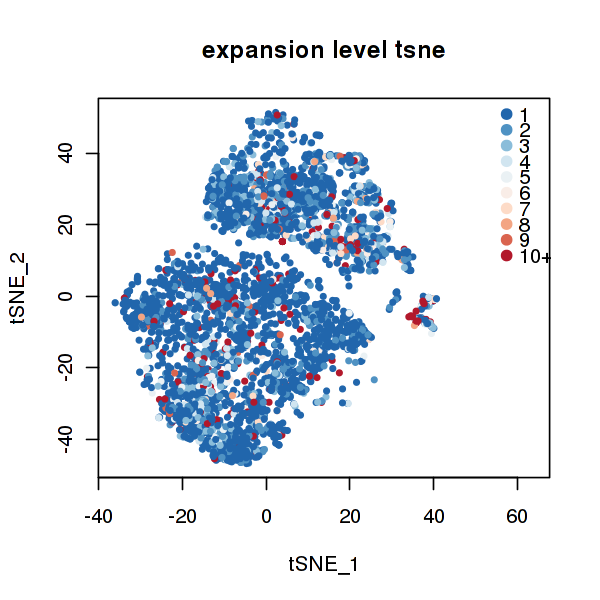

In [28]:
expansion_info_summ=data.table(position_index_matrix[!is.na(position_index_matrix$celltype),c("barcode","expand_lvl")])
expansion_info_summ=expansion_info_summ[,.(expand_lvl=max(expand_lvl)),by=barcode]
expansion_info_summ$expand_lvl[expansion_info_summ$expand_lvl>10]="10+"

source("VDJ_ploting_suite.R")
options(repr.plot.width=5, repr.plot.height=5)
plotByGroup(Exp_Seurat,Group_assignment=expansion_info_summ$expand_lvl[match(colnames(Exp_Seurat@data),expansion_info_summ$barcode)],
            Group_type=c(1:9,"10+"),main="expansion level",tagcol=colorRampPalette(rev(RColorBrewer::brewer.pal(7,"RdBu")))(10)) 